In [1]:
import torch
import numpy as np
from models import PatchMLPDiscriminator_1D_Res, Generater_MLP_Skip
from data_PET import read_data, get_data_loaders

# Load data
uPiB, uFBP, pPiB, pFBP, uPiB_CL, uFBP_CL, uPiB_scaler, uFBP_scaler = read_data(normalize=False)
val_dataloader, dataloader = get_data_loaders(uPiB, uFBP, pPiB, pFBP, uPiB_CL, uFBP_CL, 
                                                  46, resample='matching')

folder="logs_newLS_2_batch_50_pool_2500_patch_85_1_long"
folder_ft = "logs_ft8_0_batch_1_pool_50_patch_85_1_long"
setup="180_200_4_5_10.0_5.0_0.0"
setup_ft="180_200_4_5_15.0_0.0_0.0"

model_FBP_path = f'./{folder}/saved_model/{setup}/D_A_Best.pth'
model_PiB_path = f'./{folder}/saved_model/{setup}/D_B_Best.pth'
model_PiB_gen_path = f'./{folder}/saved_model/{setup}/G_AB_Best.pth'
model_FBP_gen_path = f'./{folder}/saved_model/{setup}/G_BA_Best.pth'

pFBP_fake = torch.load(f'./{folder}/data/{setup}/fake_A_Best.pt')
pPiB_fake = torch.load(f'./{folder}/data/{setup}/fake_B_Best.pt')

pPiB_fake_ft = torch.load(f'./{folder_ft}/data/{setup_ft}/fake_B_Best.pt')

Gen_FBP = Generater_MLP_Skip(85, 180, 85, 4)
Gen_PiB = Generater_MLP_Skip(85, 180, 85, 4)
Gen_FBP.load_state_dict(torch.load(model_FBP_gen_path))
Gen_PiB.load_state_dict(torch.load(model_PiB_gen_path))
Gen_FBP.eval()
Gen_PiB.eval()

Dis_FBP = PatchMLPDiscriminator_1D_Res(1, 85, 200, 5)
Dis_PiB = PatchMLPDiscriminator_1D_Res(1, 85, 200, 5)
Dis_FBP.load_state_dict(torch.load(model_FBP_path))
Dis_PiB.load_state_dict(torch.load(model_PiB_path))
Dis_FBP.eval()
Dis_PiB.eval()


# combine real uPiB and uFBP as one dataset uPiB with label 0 and uFBP with label 1
uPiB = torch.tensor(uPiB).float()
uFBP = torch.tensor(uFBP).float()
Data_cls_real = torch.cat((uPiB, uFBP))
label_cls_real = torch.cat((torch.zeros(uPiB.shape[0]), torch.ones(uFBP.shape[0])))
print(Data_cls_real.shape)

pPiB = torch.tensor(pPiB).float()
pFBP = torch.tensor(pFBP).float()
Data_cls_real_test = torch.cat((pPiB, pFBP))
label_cls_real_test = torch.cat((torch.zeros(pPiB.shape[0]), torch.ones(pFBP.shape[0])))
print(Data_cls_real_test.shape)

# data loader_real 
train_data_real = torch.utils.data.TensorDataset(Data_cls_real, label_cls_real)
train_loader_real = torch.utils.data.DataLoader(train_data_real, batch_size=128, shuffle=True)
test_data_real = torch.utils.data.TensorDataset(Data_cls_real_test, label_cls_real_test)
test_loader_real = torch.utils.data.DataLoader(test_data_real, batch_size=128, shuffle=False)

# # get fake training data
uPiB_fake = Gen_PiB(uFBP)
uFBP_fake = Gen_FBP(uPiB)
uPiB_fake = uPiB_fake.detach()
uFBP_fake = uFBP_fake.detach()
# Data_cls_fake = torch.cat((uPiB_fake, uFBP_fake))
# label_cls_fake = torch.cat((torch.zeros(uPiB_fake.shape[0]), torch.ones(uFBP_fake.shape[0])))
# # get fake testing data
# Data_cls_fake_test = torch.cat((pPiB_fake, pFBP_fake))
# label_cls_fake_test = torch.cat((torch.zeros(pPiB_fake.shape[0]), torch.ones(pFBP_fake.shape[0])))

# data loader_fake_real
train_data_fake_real_PiB = torch.cat((uPiB, uPiB_fake))
label_fake_real_PiB = torch.cat((torch.ones(uPiB.shape[0]), torch.zeros(uPiB_fake.shape[0])))
train_data_fake_real_PiB = torch.utils.data.TensorDataset(train_data_fake_real_PiB, label_fake_real_PiB)
train_loader_fake_real_PiB = torch.utils.data.DataLoader(train_data_fake_real_PiB, batch_size=128, shuffle=True)

test_data_fake_real_PiB = torch.cat((pPiB, pPiB_fake))
label_fake_real_PiB_test = torch.cat((torch.ones(pPiB.shape[0]), torch.zeros(pPiB_fake.shape[0])))
test_data_fake_real_PiB = torch.utils.data.TensorDataset(test_data_fake_real_PiB, label_fake_real_PiB_test)
test_loader_fake_real_PiB = torch.utils.data.DataLoader(test_data_fake_real_PiB, batch_size=128, shuffle=False)




1 Cerebellum-Cortex
9 Substancia-Nigra
21 ctx-corpuscallosum
57 wm-corpuscallosum
torch.Size([5883, 85])
torch.Size([92, 85])


In [2]:
from MCSUVR import cal_MCSUVR_torch, load_weights, cal_correlation
MCSUVR_WEIGHT, _, REGION_INDEX = load_weights()
mc_true = cal_MCSUVR_torch(pPiB,  REGION_INDEX, MCSUVR_WEIGHT).detach().numpy()
mc_fake = cal_MCSUVR_torch(pPiB_fake,  REGION_INDEX, MCSUVR_WEIGHT).detach().numpy()
mc_fake_ft = cal_MCSUVR_torch(pPiB_fake_ft,  REGION_INDEX, MCSUVR_WEIGHT).detach().numpy()
cor = cal_correlation(mc_true, mc_fake)
cor_ft = cal_correlation(mc_true, mc_fake_ft)

print(cor)
print(cor_ft)

import pandas as pd
pCL = pd.read_excel('./data_PET/Centioid_Summary.xlsx', sheet_name='Sheet1')

0.977845
0.9830624


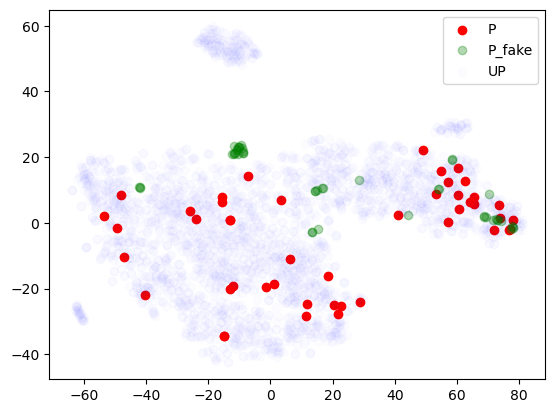

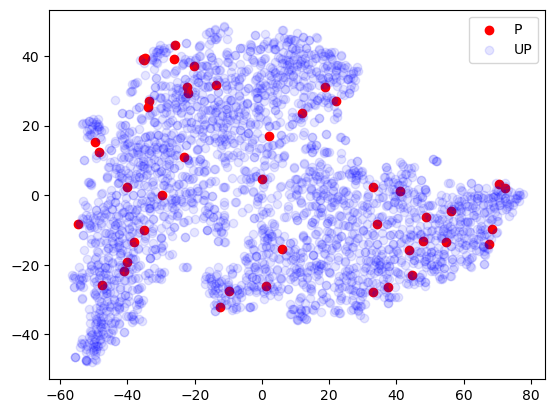

In [45]:
# do TSNE on the real data
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


tsne = TSNE(n_components=2, random_state=0)

# all_PiB = torch.cat((pPiB, pPiB_fake))
# all_PiB = torch.cat((pPiB, pPiB_fake_ft))
all_PiB = torch.cat((pPiB, uPiB, pPiB_fake_ft))
all_PiB_tsne = tsne.fit_transform(all_PiB.detach().numpy())

all_FBP = torch.cat((pFBP, uFBP))
all_FBP_tsne = tsne.fit_transform(all_FBP.detach().numpy())

plt.figure()
plt.scatter(all_PiB_tsne[:pPiB.shape[0], 0], all_PiB_tsne[:pPiB.shape[0], 1], c='r', label='P')
plt.scatter(all_PiB_tsne[pPiB.shape[0]+uPiB.shape[0]:, 0], all_PiB_tsne[pPiB.shape[0]+uPiB.shape[0]:, 1], c='g', label='P_fake', alpha=0.3)
plt.scatter(all_PiB_tsne[pPiB.shape[0]:pPiB.shape[0]+uPiB.shape[0], 0], all_PiB_tsne[pPiB.shape[0]:pPiB.shape[0]+uPiB.shape[0], 1], c='b', alpha=0.01, label='UP')
plt.legend()

plt.figure()
plt.scatter(all_FBP_tsne[:pFBP.shape[0], 0], all_FBP_tsne[:pFBP.shape[0], 1], c='r', label='P')
plt.scatter(all_FBP_tsne[pFBP.shape[0]:, 0], all_FBP_tsne[pFBP.shape[0]:, 1], c='b', alpha=0.1, label='UP')
plt.legend()

In [3]:

batchA0 = torch.load(f'./{folder_ft}/data/{setup_ft}/batch_A_0.pt')
batchA1 = torch.load(f'./{folder_ft}/data/{setup_ft}/batch_A_4.pt')
batchA2 = torch.load(f'./{folder_ft}/data/{setup_ft}/batch_A_5.pt')
batchA3 = torch.load(f'./{folder_ft}/data/{setup_ft}/batch_A_6.pt')
batchA4 = torch.load(f'./{folder_ft}/data/{setup_ft}/batch_A_7.pt')
batchA = torch.cat((batchA0, batchA1, batchA2, batchA3, batchA4))

batchB0 = torch.load(f'./{folder_ft}/data/{setup_ft}/batch_B_0.pt')
batchB1 = torch.load(f'./{folder_ft}/data/{setup_ft}/batch_B_4.pt')
batchB2 = torch.load(f'./{folder_ft}/data/{setup_ft}/batch_B_5.pt')
batchB3 = torch.load(f'./{folder_ft}/data/{setup_ft}/batch_B_6.pt')
batchB4 = torch.load(f'./{folder_ft}/data/{setup_ft}/batch_B_7.pt')

batchB = torch.cat((batchB0, batchB1, batchB2, batchB3, batchB4))

mclist = [39, 41, 42, 29, 44, 26, 28]
# mclist = [i for i in range(85)]

from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt

all_PiB = torch.cat((pPiB, uPiB, batchB))[:,mclist]
tsne = TSNE(n_components=2, random_state=0)
all_PiB_tsne = tsne.fit_transform(all_PiB.detach().numpy())

all_FBP = torch.cat((pFBP, uFBP, batchA))
tsne = TSNE(n_components=2, random_state=0)
all_FBP_tsne = tsne.fit_transform(all_FBP.detach().numpy())



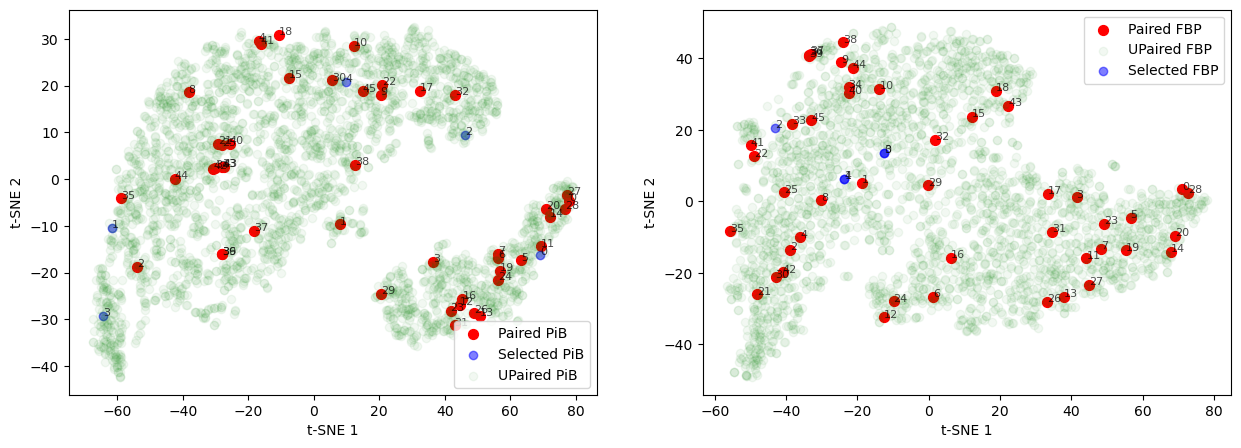

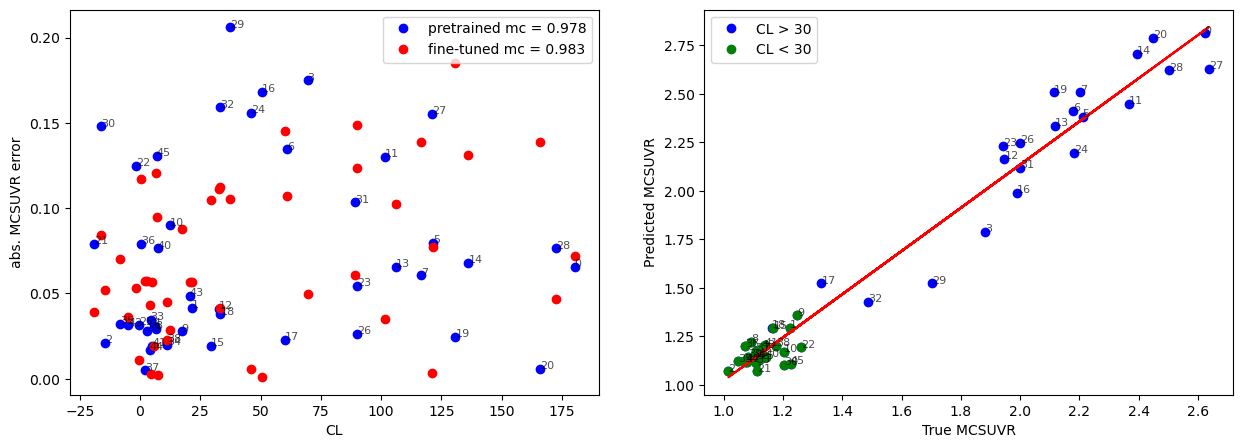

In [7]:

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(all_PiB_tsne[:pPiB.shape[0], 0], all_PiB_tsne[:pPiB.shape[0], 1], c='r', label='Paired PiB', s=50)
ax[0].scatter(all_PiB_tsne[pPiB.shape[0]+uPiB.shape[0]:, 0], all_PiB_tsne[pPiB.shape[0]+uPiB.shape[0]:, 1], c='b', label='Selected PiB', alpha=0.5)
ax[0].scatter(all_PiB_tsne[pPiB.shape[0]:pPiB.shape[0]+uPiB.shape[0], 0], all_PiB_tsne[pPiB.shape[0]:pPiB.shape[0]+uPiB.shape[0], 1], c='g', label='UPaired PiB', alpha=0.05)
ax[0].set_xlabel('t-SNE 1')
ax[0].set_ylabel('t-SNE 2')
# Annotate points with numbers
for i in range(46):
    ax[0].annotate(str(i), (all_PiB_tsne[:pPiB.shape[0], 0][i], all_PiB_tsne[:pPiB.shape[0], 1][i]), fontsize=8, alpha=0.7)
    
for i in range(5):
    ax[0].annotate(str(i), (all_PiB_tsne[pPiB.shape[0]+uPiB.shape[0]:, 0][i], all_PiB_tsne[pPiB.shape[0]+uPiB.shape[0]:, 1][i]), fontsize=8, alpha=0.7)
ax[0].legend()




ax[1].scatter(all_FBP_tsne[:pFBP.shape[0], 0], all_FBP_tsne[:pFBP.shape[0], 1], c='r', label='Paired FBP', s=50)
ax[1].scatter(all_FBP_tsne[pFBP.shape[0]:pFBP.shape[0]+uFBP.shape[0], 0], all_FBP_tsne[pFBP.shape[0]:pFBP.shape[0]+uFBP.shape[0], 1], c='g', label='UPaired FBP', alpha=0.05)
ax[1].scatter(all_FBP_tsne[pFBP.shape[0]+uFBP.shape[0]:, 0], all_FBP_tsne[pFBP.shape[0]+uFBP.shape[0]:, 1], c='b', label='Selected FBP', alpha=0.5)
# Annotate points with numbers

ax[1].set_xlabel('t-SNE 1')
ax[1].set_ylabel('t-SNE 2')
for i in range(46):
    ax[1].annotate(str(i), (all_FBP_tsne[:pFBP.shape[0], 0][i], all_FBP_tsne[:pFBP.shape[0], 1][i]), fontsize=8, alpha=0.7)

for i in range(5):
    ax[1].annotate(str(i), (all_FBP_tsne[pFBP.shape[0]+uFBP.shape[0]:, 0][i], all_FBP_tsne[pFBP.shape[0]+uFBP.shape[0]:, 1][i]), fontsize=8, alpha=0.7)

ax[1].legend()


mask = pCL['FBP_CL'] < 30
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(pCL['FBP_CL'], np.abs((mc_true - mc_fake) / mc_true), 'bo', label='pretrained mc = 0.978')
ax[0].plot(pCL['FBP_CL'], np.abs((mc_true - mc_fake_ft)/ mc_true), 'ro', label='fine-tuned mc = 0.983')
ax[0].set_xlabel('CL')
ax[0].set_ylabel('abs. MCSUVR error')

for i in range(46):
    ax[0].annotate(str(i), (pCL['FBP_CL'][i], np.abs((mc_true[i] - mc_fake[i]) / mc_true[i])), fontsize=8, alpha=0.7)

ax[0].legend()


ax[1].plot(mc_true, mc_fake_ft, 'bo', label='CL > 30')
ax[1].plot(mc_true[mask], mc_fake_ft[mask], 'go', label='CL < 30')
ax[1].set_xlabel('True MCSUVR')
ax[1].set_ylabel('Predicted MCSUVR')
ax[1].legend()
# fit a line
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(mc_true.reshape(-1, 1), mc_fake_ft)
reg.coef_
ax[1].plot(mc_true, reg.predict(mc_true.reshape(-1, 1)), 'r-') 

for i in range(46):
    ax[1].annotate(str(i), (mc_true[i], mc_fake_ft[i]), fontsize=8, alpha=0.7)

/home/yche14/.conda/envs/torch_base/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


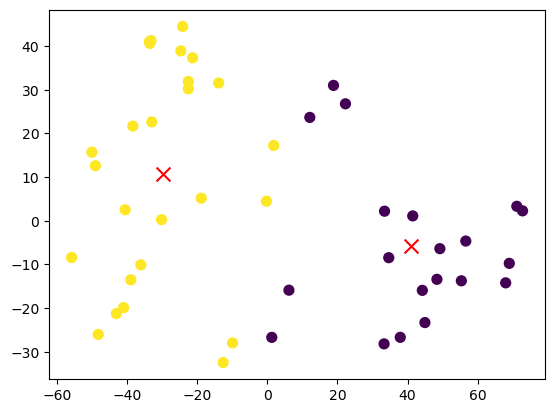

In [9]:
# Kmeans clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(all_FBP_tsne[:pFBP.shape[0]])
# plot the clustering result
plt.figure()
plt.scatter(all_FBP_tsne[:pFBP.shape[0], 0], all_FBP_tsne[:pFBP.shape[0], 1], c=kmeans.labels_, s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='r', s=100, marker='x')


In [64]:
kmeans.cluster_centers_

array([[ 41.053036 ,  -5.8537774],
       [-29.697033 ,  10.76013  ]], dtype=float32)

(array([ 8., 14.,  6.,  3.,  2.,  3.,  3.,  4.,  0.,  3.]),
 array([-18.950219 ,   0.9696411,  20.8895012,  40.8093613,  60.7292214,
         80.6490815, 100.5689416, 120.4888017, 140.4086618, 160.3285219,
        180.248382 ]),
 <BarContainer object of 10 artists>)

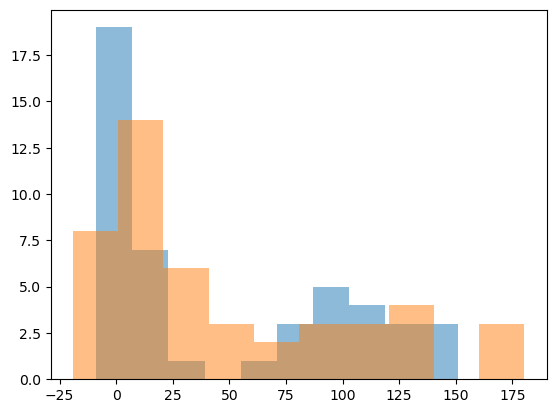

In [23]:
plt.hist(pCL['PIB_CL'], alpha=0.5)
plt.hist(pCL['FBP_CL'], alpha=0.5)

## Train a new CLS on real PiB and FBP data to directly differentiate between them

In [ ]:
Dis_NEW_real = Discriminator_MLP_Skip_OLD(85, 128, 8)
# train the new discriminator
criterion = torch.nn.BCELoss()
optimizer = torch.optim.AdamW(Dis_NEW_real.parameters(), lr=0.0001)
num_epochs = 100

for epoch in range(num_epochs):
    Dis_NEW_real.train()
    for i, (images, labels) in enumerate(train_loader_real):
        outputs = Dis_NEW_real(images)
        loss = criterion(outputs.ravel(), labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    Dis_NEW_real.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader_real:
            outputs = Dis_NEW_real(images)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.ravel() == labels).sum().item()
        
    if epoch % 10 == 0:
        print('Epoch [{}/{}], Accuracy: {:.4f}'.format(epoch+1, num_epochs, correct/total))
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


In [ ]:
Dis_NEW_fake_real_PiB = Discriminator_MLP_Skip(85, 128, 2)
# train the new discriminator
criterion = torch.nn.BCELoss()
optimizer = torch.optim.AdamW(Dis_NEW_fake_real_PiB.parameters(), lr=0.0001)
num_epochs = 100

for epoch in range(num_epochs):
    Dis_NEW_fake_real_PiB.train()
    for data, label in train_loader_fake_real_PiB:
        outputs = Dis_NEW_fake_real_PiB(data)
        loss = criterion(outputs.ravel(), label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    Dis_NEW_fake_real_PiB.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, labels in test_loader_fake_real_PiB:
            outputs = Dis_NEW_fake_real_PiB(data)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.ravel() == labels).sum().item()
    
    if epoch % 10 == 0:
        print('Epoch [{}/{}], Accuracy: {:.4f}'.format(epoch+1, num_epochs, correct/total))
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

## Discriminator evaluation on real and fake data

In [11]:
# classification real
sig = torch.nn.Sigmoid()
p_FBP_FBP = sig(Dis_FBP(pFBP))
p_FBP_PiB = sig(Dis_FBP(pPiB))

p_PiB_FBP = sig(Dis_PiB(pFBP))
p_PiB_PiB = sig(Dis_PiB(pPiB))

acc_FBP_FBP = (p_FBP_FBP > 0.5).sum().item() / p_FBP_FBP.size(0)
acc_PiB_PiB = (p_PiB_PiB > 0.5).sum().item() / p_PiB_PiB.size(0)
acc_PiB_FBP = (p_PiB_FBP < 0.5).sum().item() / p_PiB_FBP.size(0)
acc_FBP_PiB = (p_FBP_PiB < 0.5).sum().item() / p_FBP_PiB.size(0)
print('FBP_FBP: ', acc_FBP_FBP, 'PiB_PiB: ', acc_PiB_PiB, 'PiB_FBP: ', acc_PiB_FBP, 'FBP_PiB: ', acc_FBP_PiB)
print('FBP_FBP_Prob: ', p_FBP_FBP.mean().item(), 'PiB_PiB_Prob: ', p_PiB_PiB.mean().item(), 'PiB_FBP_Prob: ', p_PiB_FBP.mean().item(), 'FBP_PiB_Prob: ', p_FBP_PiB.mean().item())

# classification fake
p_FBP_FBP = Dis_FBP(pFBP_fake)
p_FBP_PiB = Dis_FBP(pPiB_fake)
p_PiB_FBP = Dis_PiB(pFBP_fake)
p_PiB_PiB = Dis_PiB(pPiB_fake)

acc_FBP_FBP = (p_FBP_FBP > 0.5).sum().item() / p_FBP_FBP.size(0)
acc_PiB_PiB = (p_PiB_PiB > 0.5).sum().item() / p_PiB_PiB.size(0)
acc_PiB_FBP = (p_PiB_FBP < 0.5).sum().item() / p_PiB_FBP.size(0)
acc_FBP_PiB = (p_FBP_PiB < 0.5).sum().item() / p_FBP_PiB.size(0)
print('FBP_FBP: ', acc_FBP_FBP, 'PiB_PiB: ', acc_PiB_PiB, 'PiB_FBP: ', acc_PiB_FBP, 'FBP_PiB: ', acc_FBP_PiB)
print('FBP_FBP_Prob: ', p_FBP_FBP.mean().item(), 'PiB_PiB_Prob: ', p_PiB_PiB.mean().item(), 'PiB_FBP_Prob: ', p_PiB_FBP.mean().item(), 'FBP_PiB_Prob: ', p_FBP_PiB.mean().item())

FBP_FBP:  0.2826086956521739 PiB_PiB:  0.32608695652173914 PiB_FBP:  0.5217391304347826 FBP_PiB:  0.8695652173913043
FBP_FBP_Prob:  0.41600725054740906 PiB_PiB_Prob:  0.3896210789680481 PiB_FBP_Prob:  0.4621768593788147 FBP_PiB_Prob:  0.27695026993751526
FBP_FBP:  0.0 PiB_PiB:  0.021739130434782608 PiB_FBP:  0.8695652173913043 FBP_PiB:  0.9130434782608695
FBP_FBP_Prob:  -0.9341450333595276 PiB_PiB_Prob:  -1.296502709388733 PiB_FBP_Prob:  -0.43764835596084595 FBP_PiB_Prob:  -0.7232757210731506


|Model|Dataset|Accuracy|ave_Prob|
|:----|:------|:------:|:------:|
|Dis_FBP|Real_FBP|0.46|0.50|
|Dis_FBP|Fake_FBP|0.39|0.50|
|Dis_FBP|Real_PiB|**0.78**|0.48|
|Dis_FBP|Fake_PiB|**0.48**|0.50|
|----|------|------|--------|
|Dis_PiB|Real_PiB|0.39|0.47|
|Dis_PiB|Fake_PiB|0.26|0.47|
|Dis_PiB|Real_FBP|**0.91**|0.42|
|Dis_PiB|Fake_FBP|**0.87**|0.38|


## New real classifier evaluation on real data

In [ ]:

p_FBP_real = Dis_NEW_real(pFBP)
p_PiB_real = Dis_NEW_real(pPiB)
p_FBP_fake = Dis_NEW_real(pFBP_fake)
p_PiB_fake = Dis_NEW_real(pPiB_fake)

acc_FBP_real = (p_FBP_real > 0.5).sum().item() / p_FBP_real.size(0)
acc_PiB_real = (p_PiB_real < 0.5).sum().item() / p_PiB_real.size(0)
acc_FBP_fake = (p_FBP_fake > 0.5).sum().item() / p_FBP_fake.size(0)
acc_PiB_fake = (p_PiB_fake < 0.5).sum().item() / p_PiB_fake.size(0)

print('FBP_real: ', acc_FBP_real, 'PiB_real: ', acc_PiB_real, 'FBP_fake: ', acc_FBP_fake, 'PiB_fake: ', acc_PiB_fake)


In [ ]:
p_PiB_FBP_real = Dis_NEW_fake_real_PiB(pFBP)
p_PiB_PiB_real = Dis_NEW_fake_real_PiB(pPiB)
p_PiB_FBP_fake = Dis_NEW_fake_real_PiB(pFBP_fake)
p_PiB_PiB_fake = Dis_NEW_fake_real_PiB(pPiB_fake)

acc_FBP_real = (p_PiB_FBP_real < 0.5).sum().item() / pFBP.size(0)
acc_PiB_real = (p_PiB_PiB_real > 0.5).sum().item() / pPiB.size(0)
acc_FBP_fake = (p_PiB_FBP_fake < 0.5).sum().item() / pFBP_fake.size(0)
acc_PiB_fake = (p_PiB_FBP_fake > 0.5).sum().item() / pPiB_fake.size(0)

print('FBP_real: ', acc_FBP_real, 'PiB_real: ', acc_PiB_real, 'FBP_fake: ', acc_FBP_fake, 'PiB_fake: ', acc_PiB_fake)


In [ ]:
import shap
shap.initjs()

def f(X):
    X = torch.tensor(X, dtype=torch.float32)
    p = Dis_NEW(X)
    return p.detach().numpy()

for data in test_loader:
    data_shap, _ = data
explainer = shap.Explainer(f, data_shap.numpy())
shap_values = explainer(data_shap.numpy())
shap.plots.beeswarm(shap_values)

In [19]:
# import matplotlib.pyplot as plt
# p_PiB_PiB_np = p_PiB_PiB.detach().numpy()
# p_PiB_FBP_np = p_PiB_FBP.detach().numpy()
# p_FBP_FBP_np = p_FBP_FBP.detach().numpy()
# p_FBP_PiB_np = p_FBP_PiB.detach().numpy()

# fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# ax[0].plot(p_PiB_PiB_np, 'ro', label='PiB data')
# ax[0].plot(p_PiB_FBP_np, 'bo', label='FBP data')
# ax[0].set_xlabel('Sample Index')
# ax[0].set_ylabel('Probability')
# ax[0].legend()
# ax[0].set_title('PiB Discriminator')

# ax[1].plot(p_FBP_PiB_np, 'ro', label='PiB data')
# ax[1].plot(p_FBP_FBP_np, 'bo', label='FBP data')
# ax[1].set_xlabel('Sample Index')
# ax[1].set_ylabel('Probability')
# ax[1].legend()
# ax[1].set_title('FBP Discriminator')

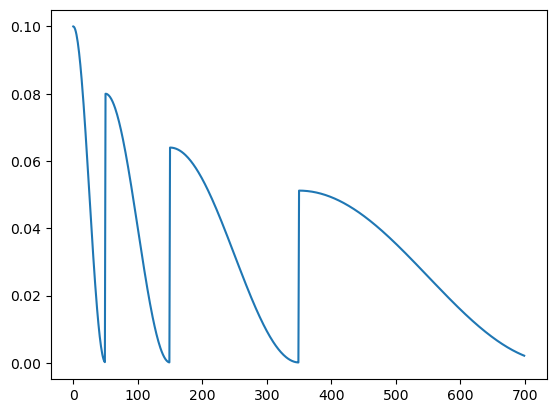

In [79]:
# print the lr by using cosine annealing with warm restarts using pytorch without math package

import torch

class CosineAnnealingLR:
    def __init__(self, optimizer, T_max, T_mult=1, eta_min=0, eta_max=0.1, decay=0.9):
        self.optimizer = optimizer
        self.decay = decay
        self.T_max = T_max
        self.T_mult = T_mult
        self.eta_min = eta_min
        self.eta_max = eta_max
        self.T_cur = 0

    def step(self):
        self.T_cur += 1
        if self.T_cur >= self.T_max:
            self.T_cur = 0
            self.eta_max *= self.decay
            self.T_max *= self.T_mult
            
            
        lr = self.eta_min + (0.5 * (self.eta_max-self.eta_min) * (1 + np.cos(np.pi * self.T_cur / self.T_max)))
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

lr = 0.1
opt = torch.optim.AdamW([torch.tensor(1.0)], lr=lr)
scheduler = CosineAnnealingLR(opt, T_max=50, eta_min=0.0001, eta_max=0.1, decay=0.8, T_mult=2)

LR = []
for epoch in range(700):
        
    LR.append(opt.param_groups[0]['lr'])
    scheduler.step()        
        
plt.plot(LR)
    
    
    


In [76]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Function

torch.manual_seed(2809)

# Set model to eval to prevent batchnorm and dropout layers of changing the output
model = models.resnet50().eval()
x = torch.randn(2, 3, 224, 224)
target = torch.randint(0, 1000, (2,))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Dummy update steps
out = model(x)
loss = criterion(out, target)
loss.backward()
print('Initial loss ', loss.item())
optimizer.step()
fc0 = model.fc.weight.detach().clone()

# Get updated loss
out = model(x)
loss = criterion(out, target)
print('Updated loss ', loss.item())
fc1 = model.fc.weight.detach().clone()

# Use negative lr
optimizer.param_groups[0]['lr'] = -1. * optimizer.param_groups[0]['lr']
optimizer.step()
out = model(x)
loss = criterion(out, target)
print('Reverted loss ', loss.item())
fc2 = model.fc.weight.detach().clone()

Initial loss  90.62640380859375
Updated loss  8.829498291015625
Reverted loss  90.62675476074219
